In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## fashion_mnist dataset 을 활용한 deep learning 학습 연습

In [2]:
(train_input , train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

target_name = {0:'t-shirt', 1:'pants', 2:'sweater', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneakers', 8:'bag', 9:'ankle_boots'}

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_target = tf.keras.utils.to_categorical(train_target) #one hot encoding
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
test_target = tf.keras.utils.to_categorical(test_target)


train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, stratify=train_target, test_size=0.2)


print(train_scaled.shape,train_target.shape)
print(val_scaled.shape,val_target.shape)

(48000, 28, 28, 1) (48000, 10)
(12000, 28, 28, 1) (12000, 10)


In [3]:
class ModelClass:
    
    def __init__(self, batch_size=32, learning_rate=1e-3):
        self.optimizer = tf.optimizers.Adam(learning_rate = learning_rate)   # 옵티마이저
        self.n_kernels1 = 32  # 합성곱의 커널 개수
        self.n_kernels2 = 64  # 합성곱의 커널 개수
        self.conv_w1 = None          # 합성곱 층의 가중치
        self.conv_b1 = None          # 합성곱 층의 절편
        self.conv_w2 = None          # 합성곱 층의 가중치
        self.conv_b2 = None          # 합성곱 층의 절편
        self.batch_size = batch_size  # 배치 크기
        self.units = 100
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        # self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(y.shape[1])    # 은닉층과 출력층의 가중치를 초기화

        for i in range(epochs):
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y): #Adam optimizer 인데 미니배치로 해도 괜찮은가?

                self.training(x_batch, y_batch)
                # 배치 손실을 기록
                batch_losses.append(self.get_loss(x_batch, y_batch))

            # 배치 손실 평균내어 훈련 손실 값으로 저장
            loss = np.mean(batch_losses)
            self.losses.append(loss)
            # 검증 세트에 대한 손실을 계산
            val_loss = self.get_loss(x_val, y_val)
            self.val_losses.append(val_loss)
            print('에포크[{}/{}] - test_loss : {} , val_loss : {}'.format(i+1, epochs, loss, val_loss))
          
    def training(self, x, y):
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행
            # 손실을 계산
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w1, self.conv_b1,
                        self.conv_w2, self.conv_b2,
                        self.w1, self.b1, 
                        self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트
        self.optimizer.apply_gradients(zip(grads, weights_list))
    
    def init_weights(self, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w1 = tf.Variable(g((3, 3, 1, self.n_kernels1)))
        self.conv_b1 = tf.Variable(np.zeros(self.n_kernels1), dtype=float)
        self.conv_w2 = tf.Variable(g((3, 3, 1, self.n_kernels2)))
        self.conv_b2 = tf.Variable(np.zeros(self.n_kernels2), dtype=float)
        n_features = 7 * 7 * self.n_kernels2
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
    
    def forpass(self, x):
        out = tf.nn.conv2d(x, self.conv_w1, strides=1, padding='SAME') + self.conv_b1
        out = tf.nn.relu(out)
        out = tf.nn.max_pool2d(out, ksize=2, strides=2, padding='VALID')

        out = tf.nn.conv2d(out, self.conv_w2, strides=1, padding='SAME') + self.conv_b2
        out = tf.nn.relu(out)
        out = tf.nn.max_pool2d(out, ksize=2, strides=2, padding='VALID')

        out = tf.reshape(out, [x.shape[0], -1])
        out = tf.matmul(out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산 : z1
        out = tf.nn.relu(out)                          # 활성화 함수를 적용 : a1
        out = tf.matmul(out, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산 : z2
        return out

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행
        # 손실을 계산하여 저장
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞기
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환
    
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
        return np.mean(self.predict(x) == np.argmax(y, axis=1))


    
# def model_fn():
#     model = keras.Sequential()
    
#     #합성곱 신경망 : 입력 데이터에 유용한 특성만 드러나도록 함
#     model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1))) #합성곱1
#     model.add(keras.layers.MaxPooling2D(2)) #풀링1  
    
#     model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1))) #합성곱2
#     model.add(keras.layers.MaxPooling2D(2)) #풀링2  

#     #밀집층
#     model.add(keras.layers.Flatten()) #밀집층에 연결하기 위한 flatten
    
#     #밀집층 : 은닉층
#     model.add(keras.layers.Dense(100,activation='relu'))
#     model.add(keras.layers.Dropout(0.4)) # 과대적합을 막기위한 dropout
    
#     #밀집층 : 출력층
#     model.add(keras.layers.Dense(10,activation='softmax'))
    
#     return model

# # 활성함수 => 신경망 회로에서, 한 노드에 대해 입력값을 다음 노드에 보낼지 말지에 대해 결정하는 함수. 

In [4]:
model = ModelClass()


# model = model_fn()
# model.summary()

In [5]:
model.fit(train_scaled, train_target,  epochs=10,
       x_val=val_scaled, y_val=val_target)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# check_point = keras.callbacks.ModelCheckpoint('best_cv_model.h5', save_best_only=True)
# early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# history = model.fit(train_scaled, train_target, epochs=20,
#                     validation_data=(val_scaled, val_target),
#                     callbacks=[check_point, early_stopping])


Metal device set to: Apple M1 Pro


2023-03-06 21:48:04.009930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-06 21:48:04.010029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


에포크[1/10] - test_loss : 0.4585227072238922 , val_loss : 0.34439557790756226
에포크[2/10] - test_loss : 0.29398688673973083 , val_loss : 0.2986551821231842
에포크[3/10] - test_loss : 0.2536662220954895 , val_loss : 0.2769806385040283
에포크[4/10] - test_loss : 0.22666797041893005 , val_loss : 0.25504809617996216
에포크[5/10] - test_loss : 0.20411664247512817 , val_loss : 0.24673254787921906
에포크[6/10] - test_loss : 0.18522587418556213 , val_loss : 0.23806831240653992
에포크[7/10] - test_loss : 0.16659200191497803 , val_loss : 0.2794772982597351
에포크[8/10] - test_loss : 0.15108215808868408 , val_loss : 0.2620401084423065
에포크[9/10] - test_loss : 0.1355602741241455 , val_loss : 0.23916566371917725
에포크[10/10] - test_loss : 0.12016723304986954 , val_loss : 0.2562342584133148


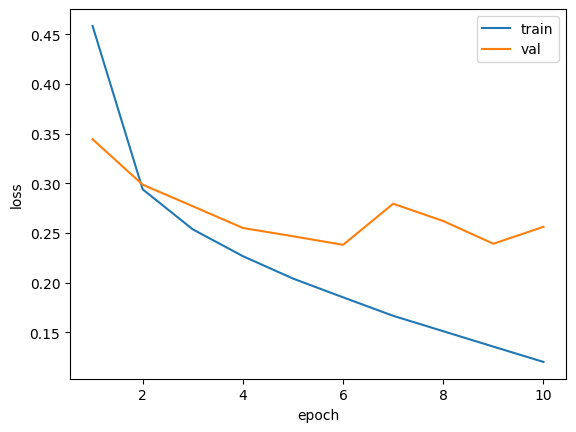

In [6]:
plt.plot(np.linspace(1,len(model.losses),len(model.losses)), model.losses)
plt.plot(np.linspace(1,len(model.val_losses),len(model.val_losses)), model.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# plt.plot(np.linspace(1,len(history.history['loss']),len(history.history['loss'])), history.history['loss'])
# plt.plot(np.linspace(1,len(history.history['val_loss']),len(history.history['val_loss'])), history.history['val_loss'])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train','val'])
# plt.show()

# print('best_epoch :', early_stopping.best_epoch + 1)

In [8]:
model.score(test_scaled, test_target)

0.9095